In [390]:
!pip install opencv-python

In [391]:
# imports all
import torch
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.batchnorm import _BatchNorm
from torch.nn.parallel._functions import ReduceAddCoalesced, Broadcast
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.utils.model_zoo as model_zoo

import argparse
import cv2
import collections
from collections import OrderedDict
import copy
from __future__ import print_function, division
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle as pkl
from PIL import Image, ImageOps
import queue
import random
import scipy.sparse as sp
import sys
# import timeit
# import threading

In [392]:
# graph.ipynb
cihp_graph = {0: [],
              1: [2, 13],
              2: [1, 13],
              3: [14, 15],
              4: [13],
              5: [6, 7, 9, 10, 11, 12, 14, 15],
              6: [5, 7, 10, 11, 14, 15, 16, 17],
              7: [5, 6, 9, 10, 11, 12, 14, 15],
              8: [16, 17, 18, 19],
              9: [5, 7, 10, 16, 17, 18, 19],
              10:[5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17],
              11:[5, 6, 7, 10, 13],
              12:[5, 7, 10, 16, 17],
              13:[1, 2, 4, 10, 11],
              14:[3, 5, 6, 7, 10],
              15:[3, 5, 6, 7, 10],
              16:[6, 8, 9, 10, 12, 18],
              17:[6, 8, 9, 10, 12, 19],
              18:[8, 9, 16],
              19:[8, 9, 17]}
cihp2pascal_adj = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                              [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
                              [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]])

pascal_graph = {0:[0],
                1:[1, 2],
                2:[1, 2, 3, 5],
                3:[2, 3, 4],
                4:[3, 4],
                5:[2, 5, 6],
                6:[5, 6]}

cihp_graph = {0: [],
              1: [2, 13],
              2: [1, 13],
              3: [14, 15],
              4: [13],
              5: [6, 7, 9, 10, 11, 12, 14, 15],
              6: [5, 7, 10, 11, 14, 15, 16, 17],
              7: [5, 6, 9, 10, 11, 12, 14, 15],
              8: [16, 17, 18, 19],
              9: [5, 7, 10, 16, 17, 18, 19],
              10:[5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17],
              11:[5, 6, 7, 10, 13],
              12:[5, 7, 10, 16, 17],
              13:[1, 2, 4, 10, 11],
              14:[3, 5, 6, 7, 10],
              15:[3, 5, 6, 7, 10],
              16:[6, 8, 9, 10, 12, 18],
              17:[6, 8, 9, 10, 12, 19],
              18:[8, 9, 16],
              19:[8, 9, 17]}

atr_graph = {0: [],
              1: [2, 11],
              2: [1, 11],
              3: [11],
              4: [5, 6, 7, 11, 14, 15, 17],
              5: [4, 6, 7, 8, 12, 13],
              6: [4,5,7,8,9,10,12,13],
              7: [4,11,12,13,14,15],
              8: [5,6],
              9: [6, 12],
              10:[6, 13],
              11:[1,2,3,4,7,14,15,17],
              12:[5,6,7,9],
              13:[5,6,7,10],
              14:[4,7,11,16],
              15:[4,7,11,16],
              16:[14,15],
              17:[4,11],
              }

cihp2pascal_adj = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                              [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
                              [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]])

cihp2pascal_nlp_adj = \
    np.array([[ 1.,  0.35333052,  0.32727194,  0.17418084,  0.18757584,
         0.40608522,  0.37503981,  0.35448462,  0.22598555,  0.23893579,
         0.33064262,  0.28923404,  0.27986573,  0.4211553 ,  0.36915778,
         0.41377746,  0.32485771,  0.37248222,  0.36865639,  0.41500332],
       [ 0.39615879,  0.46201529,  0.52321467,  0.30826114,  0.25669527,
         0.54747773,  0.3670523 ,  0.3901983 ,  0.27519473,  0.3433325 ,
         0.52728509,  0.32771333,  0.34819325,  0.63882953,  0.68042925,
         0.69368576,  0.63395791,  0.65344337,  0.59538781,  0.6071375 ],
       [ 0.16373166,  0.21663339,  0.3053872 ,  0.28377612,  0.1372435 ,
         0.4448808 ,  0.29479995,  0.31092595,  0.22703953,  0.33983576,
         0.75778818,  0.2619818 ,  0.37069392,  0.35184867,  0.49877512,
         0.49979437,  0.51853277,  0.52517541,  0.32517741,  0.32377309],
       [ 0.32687232,  0.38482461,  0.37693463,  0.41610834,  0.20415749,
         0.76749079,  0.35139853,  0.3787411 ,  0.28411737,  0.35155421,
         0.58792618,  0.31141718,  0.40585111,  0.51189218,  0.82042737,
         0.8342413 ,  0.70732188,  0.72752501,  0.60327325,  0.61431337],
       [ 0.34069369,  0.34817292,  0.37525998,  0.36497069,  0.17841617,
         0.69746208,  0.31731463,  0.34628951,  0.25167277,  0.32072379,
         0.56711286,  0.24894776,  0.37000453,  0.52600859,  0.82483993,
         0.84966274,  0.7033991 ,  0.73449378,  0.56649608,  0.58888791],
       [ 0.28477487,  0.35139564,  0.42742352,  0.41664321,  0.20004676,
         0.78566833,  0.42237487,  0.41048549,  0.37933812,  0.46542516,
         0.62444759,  0.3274493 ,  0.49466009,  0.49314658,  0.71244233,
         0.71497003,  0.8234787 ,  0.83566589,  0.62597135,  0.62626812],
       [ 0.3011378 ,  0.31775977,  0.42922647,  0.36896257,  0.17597556,
         0.72214655,  0.39162804,  0.38137872,  0.34980296,  0.43818419,
         0.60879174,  0.26762545,  0.46271161,  0.51150476,  0.72318109,
         0.73678399,  0.82620388,  0.84942166,  0.5943811 ,  0.60607602]])

pascal2atr_nlp_adj = \
    np.array([[ 1.,  0.35333052,  0.32727194,  0.18757584,  0.40608522,
         0.27986573,  0.23893579,  0.27600672,  0.30964391,  0.36865639,
         0.41500332,  0.4211553 ,  0.32485771,  0.37248222,  0.36915778,
         0.41377746,  0.32006291,  0.28923404],
       [ 0.39615879,  0.46201529,  0.52321467,  0.25669527,  0.54747773,
         0.34819325,  0.3433325 ,  0.26603942,  0.45162929,  0.59538781,
         0.6071375 ,  0.63882953,  0.63395791,  0.65344337,  0.68042925,
         0.69368576,  0.44354613,  0.32771333],
       [ 0.16373166,  0.21663339,  0.3053872 ,  0.1372435 ,  0.4448808 ,
         0.37069392,  0.33983576,  0.26563416,  0.35443504,  0.32517741,
         0.32377309,  0.35184867,  0.51853277,  0.52517541,  0.49877512,
         0.49979437,  0.21750868,  0.2619818 ],
       [ 0.32687232,  0.38482461,  0.37693463,  0.20415749,  0.76749079,
         0.40585111,  0.35155421,  0.28271333,  0.52684576,  0.60327325,
         0.61431337,  0.51189218,  0.70732188,  0.72752501,  0.82042737,
         0.8342413 ,  0.40137029,  0.31141718],
       [ 0.34069369,  0.34817292,  0.37525998,  0.17841617,  0.69746208,
         0.37000453,  0.32072379,  0.27268885,  0.47426719,  0.56649608,
         0.58888791,  0.52600859,  0.7033991 ,  0.73449378,  0.82483993,
         0.84966274,  0.37830796,  0.24894776],
       [ 0.28477487,  0.35139564,  0.42742352,  0.20004676,  0.78566833,
         0.49466009,  0.46542516,  0.32662614,  0.55780359,  0.62597135,
         0.62626812,  0.49314658,  0.8234787 ,  0.83566589,  0.71244233,
         0.71497003,  0.41223219,  0.3274493 ],
       [ 0.3011378 ,  0.31775977,  0.42922647,  0.17597556,  0.72214655,
         0.46271161,  0.43818419,  0.3192333 ,  0.50979216,  0.5943811 ,
         0.60607602,  0.51150476,  0.82620388,  0.84942166,  0.72318109,
         0.73678399,  0.39259827,  0.26762545]])

cihp2atr_nlp_adj = np.array([[ 1.,  0.35333052,  0.32727194,  0.18757584,  0.40608522,
         0.27986573,  0.23893579,  0.27600672,  0.30964391,  0.36865639,
         0.41500332,  0.4211553 ,  0.32485771,  0.37248222,  0.36915778,
         0.41377746,  0.32006291,  0.28923404],
       [ 0.35333052,  1.        ,  0.39206695,  0.42143438,  0.4736689 ,
         0.47139544,  0.51999208,  0.38354847,  0.45628529,  0.46514124,
         0.50083501,  0.4310595 ,  0.39371443,  0.4319752 ,  0.42938598,
         0.46384034,  0.44833757,  0.6153155 ],
       [ 0.32727194,  0.39206695,  1.        ,  0.32836702,  0.52603065,
         0.39543695,  0.3622627 ,  0.43575346,  0.33866223,  0.45202552,
         0.48421   ,  0.53669903,  0.47266611,  0.50925436,  0.42286557,
         0.45403656,  0.37221304,  0.40999322],
       [ 0.17418084,  0.46892601,  0.25774838,  0.31816231,  0.39330317,
         0.34218382,  0.48253904,  0.22084125,  0.41335728,  0.52437572,
         0.5191713 ,  0.33576117,  0.44230914,  0.44250678,  0.44330833,
         0.43887264,  0.50693611,  0.39278795],
       [ 0.18757584,  0.42143438,  0.32836702,  1.        ,  0.35030067,
         0.30110947,  0.41055555,  0.34338879,  0.34336307,  0.37704433,
         0.38810141,  0.34702081,  0.24171562,  0.25433078,  0.24696241,
         0.2570884 ,  0.4465962 ,  0.45263213],
       [ 0.40608522,  0.4736689 ,  0.52603065,  0.35030067,  1.        ,
         0.54372584,  0.58300258,  0.56674191,  0.555266  ,  0.66599594,
         0.68567555,  0.55716359,  0.62997328,  0.65638548,  0.61219615,
         0.63183318,  0.54464151,  0.44293752],
       [ 0.37503981,  0.50675565,  0.4761106 ,  0.37561813,  0.60419403,
         0.77912403,  0.64595517,  0.85939662,  0.46037144,  0.52348817,
         0.55875094,  0.37741886,  0.455671  ,  0.49434392,  0.38479954,
         0.41804074,  0.47285709,  0.57236283],
       [ 0.35448462,  0.50576632,  0.51030446,  0.35841033,  0.55106903,
         0.50257274,  0.52591451,  0.4283053 ,  0.39991808,  0.42327211,
         0.42853819,  0.42071825,  0.41240559,  0.42259136,  0.38125352,
         0.3868255 ,  0.47604934,  0.51811717],
       [ 0.22598555,  0.5053299 ,  0.36301185,  0.38002282,  0.49700941,
         0.45625243,  0.62876479,  0.4112051 ,  0.33944371,  0.48322639,
         0.50318714,  0.29207815,  0.38801966,  0.41119094,  0.29199072,
         0.31021029,  0.41594871,  0.54961962],
       [ 0.23893579,  0.51999208,  0.3622627 ,  0.41055555,  0.58300258,
         0.68874251,  1.        ,  0.56977937,  0.49918447,  0.48484363,
         0.51615925,  0.41222306,  0.49535971,  0.53134951,  0.3807616 ,
         0.41050298,  0.48675801,  0.51112664],
       [ 0.33064262,  0.306412  ,  0.60679935,  0.25592294,  0.58738706,
         0.40379627,  0.39679161,  0.33618385,  0.39235148,  0.45474013,
         0.4648476 ,  0.59306762,  0.58976007,  0.60778661,  0.55400397,
         0.56551297,  0.3698029 ,  0.33860535],
       [ 0.28923404,  0.6153155 ,  0.40999322,  0.45263213,  0.44293752,
         0.60359359,  0.51112664,  0.46578181,  0.45656936,  0.38142307,
         0.38525582,  0.33327223,  0.35360175,  0.36156453,  0.3384992 ,
         0.34261229,  0.49297863,  1.        ],
       [ 0.27986573,  0.47139544,  0.39543695,  0.30110947,  0.54372584,
         1.        ,  0.68874251,  0.67765588,  0.48690078,  0.44010641,
         0.44921156,  0.32321099,  0.48311542,  0.4982002 ,  0.39378102,
         0.40297733,  0.45309735,  0.60359359],
       [ 0.4211553 ,  0.4310595 ,  0.53669903,  0.34702081,  0.55716359,
         0.32321099,  0.41222306,  0.25721705,  0.36633509,  0.5397475 ,
         0.56429928,  1.        ,  0.55796926,  0.58842844,  0.57930828,
         0.60410597,  0.41615326,  0.33327223],
       [ 0.36915778,  0.42938598,  0.42286557,  0.24696241,  0.61219615,
         0.39378102,  0.3807616 ,  0.28089866,  0.48450394,  0.77400821,
         0.68813814,  0.57930828,  0.8856886 ,  0.81673412,  1.        ,
         0.92279623,  0.46969152,  0.3384992 ],
       [ 0.41377746,  0.46384034,  0.45403656,  0.2570884 ,  0.63183318,
         0.40297733,  0.41050298,  0.332879  ,  0.48799542,  0.69231828,
         0.77015091,  0.60410597,  0.79788484,  0.88232104,  0.92279623,
         1.        ,  0.45685017,  0.34261229],
       [ 0.32485771,  0.39371443,  0.47266611,  0.24171562,  0.62997328,
         0.48311542,  0.49535971,  0.32477932,  0.51486622,  0.79353556,
         0.69768738,  0.55796926,  1.        ,  0.92373745,  0.8856886 ,
         0.79788484,  0.47883134,  0.35360175],
       [ 0.37248222,  0.4319752 ,  0.50925436,  0.25433078,  0.65638548,
         0.4982002 ,  0.53134951,  0.38057074,  0.52403969,  0.72035243,
         0.78711147,  0.58842844,  0.92373745,  1.        ,  0.81673412,
         0.88232104,  0.47109935,  0.36156453],
       [ 0.36865639,  0.46514124,  0.45202552,  0.37704433,  0.66599594,
         0.44010641,  0.48484363,  0.39636574,  0.50175258,  1.        ,
         0.91320249,  0.5397475 ,  0.79353556,  0.72035243,  0.77400821,
         0.69231828,  0.59087008,  0.38142307],
       [ 0.41500332,  0.50083501,  0.48421,  0.38810141,  0.68567555,
         0.44921156,  0.51615925,  0.45156472,  0.50438158,  0.91320249,
         1.,  0.56429928,  0.69768738,  0.78711147,  0.68813814,
         0.77015091,  0.57698754,  0.38525582]])

cihp_20to5 = np.array(
    [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0],
     [0, 0, 1, 0, 0], [0, 0, 1, 0, 0],
     [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 1], [0, 1, 0, 0, 0],
     [0, 0, 0, 1, 0], [0, 0, 0, 1, 0],
     [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]])

cihp_5to2 = np.array([[1, 0], [0, 1], [0, 1], [0, 1], [0, 1]])


def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(adj)) # return a adjacency matrix of adj ( type is numpy)
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0])) #
    # return sparse_to_tuple(adj_normalized)
    return adj_normalized.todense()

def row_norm(inputs):
    outputs = []
    for x in inputs:
        xsum = x.sum()
        x = x / xsum
        outputs.append(x)
    return outputs

def normalize_adj_torch(adj):
    # print(adj.size())
    if len(adj.size()) == 4:
        new_r = torch.zeros(adj.size()).type_as(adj)
        for i in range(adj.size(1)):
            adj_item = adj[0,i]
            rowsum = adj_item.sum(1)
            d_inv_sqrt = rowsum.pow_(-0.5)
            d_inv_sqrt[torch.isnan(d_inv_sqrt)] = 0
            d_mat_inv_sqrt = torch.diag(d_inv_sqrt)
            r = torch.matmul(torch.matmul(d_mat_inv_sqrt, adj_item), d_mat_inv_sqrt)
            new_r[0,i,...] = r
        return new_r
    rowsum = adj.sum(1)
    d_inv_sqrt = rowsum.pow_(-0.5)
    d_inv_sqrt[torch.isnan(d_inv_sqrt)] = 0
    d_mat_inv_sqrt = torch.diag(d_inv_sqrt)
    r = torch.matmul(torch.matmul(d_mat_inv_sqrt,adj),d_mat_inv_sqrt)
    return r

In [393]:
class SyncMaster(object):
    """An abstract `SyncMaster` object.
    - During the replication, as the data parallel will trigger an callback of each module, all slave devices should
    call `register(id)` and obtain an `SlavePipe` to communicate with the master.
    - During the forward pass, master device invokes `run_master`, all messages from slave devices will be collected,
    and passed to a registered callback.
    - After receiving the messages, the master device should gather the information and determine to message passed
    back to each slave devices.
    """

    def __init__(self, master_callback):
        """
        Args:
            master_callback: a callback to be invoked after having collected messages from slave devices.
        """
        self._master_callback = master_callback
        self._queue = queue.Queue()
        self._registry = collections.OrderedDict()
        self._activated = False

In [394]:
# batchnorm
# from .comm import SyncMaster

__all__ = ['SynchronizedBatchNorm1d', 'SynchronizedBatchNorm2d', 'SynchronizedBatchNorm3d']


def _sum_ft(tensor):
    """sum over the first and last dimention"""
    return tensor.sum(dim=0).sum(dim=-1)


def _unsqueeze_ft(tensor):
    """add new dementions at the front and the tail"""
    return tensor.unsqueeze(0).unsqueeze(-1)


_ChildMessage = collections.namedtuple('_ChildMessage', ['sum', 'ssum', 'sum_size'])
_MasterMessage = collections.namedtuple('_MasterMessage', ['sum', 'inv_std'])


class _SynchronizedBatchNorm(_BatchNorm):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True):
        super(_SynchronizedBatchNorm, self).__init__(num_features, eps=eps, momentum=momentum, affine=affine)

        self._sync_master = SyncMaster(self._data_parallel_master)

        self._is_parallel = False
        self._parallel_id = None
        self._slave_pipe = None

    def forward(self, input):
        # If it is not parallel computation or is in evaluation mode, use PyTorch's implementation.
        if not (self._is_parallel and self.training):
            return F.batch_norm(
                input, self.running_mean, self.running_var, self.weight, self.bias,
                self.training, self.momentum, self.eps)

        # Resize the input to (B, C, -1).
        input_shape = input.size()
        input = input.view(input.size(0), self.num_features, -1)

        # Compute the sum and square-sum.
        sum_size = input.size(0) * input.size(2)
        input_sum = _sum_ft(input)
        input_ssum = _sum_ft(input ** 2)

        # Reduce-and-broadcast the statistics.
        if self._parallel_id == 0:
            mean, inv_std = self._sync_master.run_master(_ChildMessage(input_sum, input_ssum, sum_size))
        else:
            mean, inv_std = self._slave_pipe.run_slave(_ChildMessage(input_sum, input_ssum, sum_size))

        # Compute the output.
        if self.affine:
            # MJY:: Fuse the multiplication for speed.
            output = (input - _unsqueeze_ft(mean)) * _unsqueeze_ft(inv_std * self.weight) + _unsqueeze_ft(self.bias)
        else:
            output = (input - _unsqueeze_ft(mean)) * _unsqueeze_ft(inv_std)

        # Reshape it.
        return output.view(input_shape)

    def __data_parallel_replicate__(self, ctx, copy_id):
        self._is_parallel = True
        self._parallel_id = copy_id

        # parallel_id == 0 means master device.
        if self._parallel_id == 0:
            ctx.sync_master = self._sync_master
        else:
            self._slave_pipe = ctx.sync_master.register_slave(copy_id)

    def _data_parallel_master(self, intermediates):
        """Reduce the sum and square-sum, compute the statistics, and broadcast it."""

        # Always using same "device order" makes the ReduceAdd operation faster.
        # Thanks to:: Tete Xiao (http://tetexiao.com/)
        intermediates = sorted(intermediates, key=lambda i: i[1].sum.get_device())

        to_reduce = [i[1][:2] for i in intermediates]
        to_reduce = [j for i in to_reduce for j in i]  # flatten
        target_gpus = [i[1].sum.get_device() for i in intermediates]

        sum_size = sum([i[1].sum_size for i in intermediates])
        sum_, ssum = ReduceAddCoalesced.apply(target_gpus[0], 2, *to_reduce)
        mean, inv_std = self._compute_mean_std(sum_, ssum, sum_size)

        broadcasted = Broadcast.apply(target_gpus, mean, inv_std)

        outputs = []
        for i, rec in enumerate(intermediates):
            outputs.append((rec[0], _MasterMessage(*broadcasted[i*2:i*2+2])))

        return outputs

    def _compute_mean_std(self, sum_, ssum, size):
        """Compute the mean and standard-deviation with sum and square-sum. This method
        also maintains the moving average on the master device."""
        assert size > 1, 'BatchNorm computes unbiased standard-deviation, which requires size > 1.'
        mean = sum_ / size
        sumvar = ssum - sum_ * mean
        unbias_var = sumvar / (size - 1)
        bias_var = sumvar / size

        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean.data
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * unbias_var.data

        return mean, bias_var.clamp(self.eps) ** -0.5


class SynchronizedBatchNorm1d(_SynchronizedBatchNorm):
    r"""Applies Synchronized Batch Normalization over a 2d or 3d input that is seen as a
    mini-batch.

    .. math::

        y = \frac{x - mean[x]}{ \sqrt{Var[x] + \epsilon}} * gamma + beta

    This module differs from the built-in PyTorch BatchNorm1d as the mean and
    standard-deviation are reduced across all devices during training.

    For example, when one uses `nn.DataParallel` to wrap the network during
    training, PyTorch's implementation normalize the tensor on each device using
    the statistics only on that device, which accelerated the computation and
    is also easy to implement, but the statistics might be inaccurate.
    Instead, in this synchronized version, the statistics will be computed
    over all training samples distributed on multiple devices.
    
    Note that, for one-GPU or CPU-only case, this module behaves exactly same
    as the built-in PyTorch implementation.

    The mean and standard-deviation are calculated per-dimension over
    the mini-batches and gamma and beta are learnable parameter vectors
    of size C (where C is the input size).

    During training, this layer keeps a running estimate of its computed mean
    and variance. The running sum is kept with a default momentum of 0.1.

    During evaluation, this running mean/variance is used for normalization.

    Because the BatchNorm is done over the `C` dimension, computing statistics
    on `(N, L)` slices, it's common terminology to call this Temporal BatchNorm

    Args:
        num_features: num_features from an expected input of size
            `batch_size x num_features [x width]`
        eps: a value added to the denominator for numerical stability.
            Default: 1e-5
        momentum: the value used for the running_mean and running_var
            computation. Default: 0.1
        affine: a boolean value that when set to ``True``, gives the layer learnable
            affine parameters. Default: ``True``

    Shape:
        - Input: :math:`(N, C)` or :math:`(N, C, L)`
        - Output: :math:`(N, C)` or :math:`(N, C, L)` (same shape as input)

    Examples:
        >>> # With Learnable Parameters
        >>> m = SynchronizedBatchNorm1d(100)
        >>> # Without Learnable Parameters
        >>> m = SynchronizedBatchNorm1d(100, affine=False)
        >>> input = torch.autograd.Variable(torch.randn(20, 100))
        >>> output = m(input)
    """

    def _check_input_dim(self, input):
        if input.dim() != 2 and input.dim() != 3:
            raise ValueError('expected 2D or 3D input (got {}D input)'
                             .format(input.dim()))
        super(SynchronizedBatchNorm1d, self)._check_input_dim(input)


class SynchronizedBatchNorm2d(_SynchronizedBatchNorm):
    r"""Applies Batch Normalization over a 4d input that is seen as a mini-batch
    of 3d inputs

    .. math::

        y = \frac{x - mean[x]}{ \sqrt{Var[x] + \epsilon}} * gamma + beta

    This module differs from the built-in PyTorch BatchNorm2d as the mean and
    standard-deviation are reduced across all devices during training.

    For example, when one uses `nn.DataParallel` to wrap the network during
    training, PyTorch's implementation normalize the tensor on each device using
    the statistics only on that device, which accelerated the computation and
    is also easy to implement, but the statistics might be inaccurate.
    Instead, in this synchronized version, the statistics will be computed
    over all training samples distributed on multiple devices.
    
    Note that, for one-GPU or CPU-only case, this module behaves exactly same
    as the built-in PyTorch implementation.

    The mean and standard-deviation are calculated per-dimension over
    the mini-batches and gamma and beta are learnable parameter vectors
    of size C (where C is the input size).

    During training, this layer keeps a running estimate of its computed mean
    and variance. The running sum is kept with a default momentum of 0.1.

    During evaluation, this running mean/variance is used for normalization.

    Because the BatchNorm is done over the `C` dimension, computing statistics
    on `(N, H, W)` slices, it's common terminology to call this Spatial BatchNorm

    Args:
        num_features: num_features from an expected input of
            size batch_size x num_features x height x width
        eps: a value added to the denominator for numerical stability.
            Default: 1e-5
        momentum: the value used for the running_mean and running_var
            computation. Default: 0.1
        affine: a boolean value that when set to ``True``, gives the layer learnable
            affine parameters. Default: ``True``

    Shape:
        - Input: :math:`(N, C, H, W)`
        - Output: :math:`(N, C, H, W)` (same shape as input)

    Examples:
        >>> # With Learnable Parameters
        >>> m = SynchronizedBatchNorm2d(100)
        >>> # Without Learnable Parameters
        >>> m = SynchronizedBatchNorm2d(100, affine=False)
        >>> input = torch.autograd.Variable(torch.randn(20, 100, 35, 45))
        >>> output = m(input)
    """

    def _check_input_dim(self, input):
        if input.dim() != 4:
            raise ValueError('expected 4D input (got {}D input)'
                             .format(input.dim()))
        super(SynchronizedBatchNorm2d, self)._check_input_dim(input)


class SynchronizedBatchNorm3d(_SynchronizedBatchNorm):
    r"""Applies Batch Normalization over a 5d input that is seen as a mini-batch
    of 4d inputs

    .. math::

        y = \frac{x - mean[x]}{ \sqrt{Var[x] + \epsilon}} * gamma + beta

    This module differs from the built-in PyTorch BatchNorm3d as the mean and
    standard-deviation are reduced across all devices during training.

    For example, when one uses `nn.DataParallel` to wrap the network during
    training, PyTorch's implementation normalize the tensor on each device using
    the statistics only on that device, which accelerated the computation and
    is also easy to implement, but the statistics might be inaccurate.
    Instead, in this synchronized version, the statistics will be computed
    over all training samples distributed on multiple devices.
    
    Note that, for one-GPU or CPU-only case, this module behaves exactly same
    as the built-in PyTorch implementation.

    The mean and standard-deviation are calculated per-dimension over
    the mini-batches and gamma and beta are learnable parameter vectors
    of size C (where C is the input size).

    During training, this layer keeps a running estimate of its computed mean
    and variance. The running sum is kept with a default momentum of 0.1.

    During evaluation, this running mean/variance is used for normalization.

    Because the BatchNorm is done over the `C` dimension, computing statistics
    on `(N, D, H, W)` slices, it's common terminology to call this Volumetric BatchNorm
    or Spatio-temporal BatchNorm

    Args:
        num_features: num_features from an expected input of
            size batch_size x num_features x depth x height x width
        eps: a value added to the denominator for numerical stability.
            Default: 1e-5
        momentum: the value used for the running_mean and running_var
            computation. Default: 0.1
        affine: a boolean value that when set to ``True``, gives the layer learnable
            affine parameters. Default: ``True``

    Shape:
        - Input: :math:`(N, C, D, H, W)`
        - Output: :math:`(N, C, D, H, W)` (same shape as input)

    Examples:
        >>> # With Learnable Parameters
        >>> m = SynchronizedBatchNorm3d(100)
        >>> # Without Learnable Parameters
        >>> m = SynchronizedBatchNorm3d(100, affine=False)
        >>> input = torch.autograd.Variable(torch.randn(20, 100, 35, 45, 10))
        >>> output = m(input)
    """

    def _check_input_dim(self, input):
        if input.dim() != 5:
            raise ValueError('expected 5D input (got {}D input)'
                             .format(input.dim()))
        super(SynchronizedBatchNorm3d, self)._check_input_dim(input)


In [395]:
# gcn.ipynb

class Self_Attn_instead_of_GCN_SYNBN_no_gamma(nn.Module):
    """ Self attention Layer"""

    def __init__(self, in_dim, activation):
        super(Self_Attn_instead_of_GCN_SYNBN_no_gamma, self).__init__()
        self.chanel_in = in_dim

        # But here we are not using activation function
        self.activation = activation

        self.query_conv = nn.Conv1d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv1d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv1d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        # self.gamma = nn.Parameter(torch.zeros(1))

        self.bn = SynchronizedBatchNorm1d(in_dim)

        self.softmax = nn.Softmax(dim=-1)  #

    def forward(self, x, adj=None):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize, C, class_num = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, class_num).permute(0, 2, 1)  # B X CX(N)
        proj_key = self.key_conv(x).view(m_batchsize, -1, class_num)  # B X C x (*W*H)
        energy = torch.bmm(proj_query, proj_key)  # transpose check
        attention = self.softmax(energy)  # BX (N) X (N)

        # Here we use synBN
        proj_value = self.value_conv(self.bn(x)).view(m_batchsize, -1, class_num)  # B X C X N
        # proj_value = self.value_conv(x).view(m_batchsize, -1, class_num)  # B X C X N
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))

        out = out.view(m_batchsize, C, class_num)
        out = out + x

        return out, attention


class GraphContextReasoning(nn.Module):
    """ Self attention Layer"""

    def __init__(self, in_dim, activation):
        super(GraphContextReasoning, self).__init__()
        self.chanel_in = in_dim

        # But here we are not using activation function
        self.activation = activation

        self.query_conv = nn.Conv1d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv1d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv1d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        # self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax = nn.Softmax(dim=-1)  #

    def forward(self, x, adj=None):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize, C, class_num = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, class_num).permute(0, 2, 1)  # B X CX(N)
        proj_key = self.key_conv(x).view(m_batchsize, -1, class_num)  # B X C x (*W*H)
        energy = torch.bmm(proj_query, proj_key)  # transpose check
        attention = self.softmax(energy)  # BX (N) X (N)

        # Here we use synBN
        proj_value = self.value_conv(x).view(m_batchsize, -1, class_num)  # B X C X N
        # proj_value = self.value_conv(x).view(m_batchsize, -1, class_num)  # B X C X N
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))

        out = out.view(m_batchsize, C, class_num)
        out = out + x

        return out, attention

In [396]:
# graph_pyramid
# Blocks
class LevelReasoning(nn.Module):
    def __init__(self, n_classes=7, hidden_layers=256, graph_hidden_layers=512):
        super(LevelReasoning, self).__init__()

        self.hidden_layers = hidden_layers
        self.nclasses = n_classes

        self.graph_transfer = nn.Conv1d(graph_hidden_layers, graph_hidden_layers, kernel_size=1, stride=1)
        self.graph_transfer_back = nn.Conv1d(graph_hidden_layers, hidden_layers, kernel_size=1, stride=1)

        self.attn1 = GraphContextReasoning(graph_hidden_layers, 'relu')
        self.attn2 = GraphContextReasoning(graph_hidden_layers, 'relu')
        self.attn3 = GraphContextReasoning(graph_hidden_layers, 'relu')

        self.bn1 = SynchronizedBatchNorm1d(graph_hidden_layers)
        self.bn2 = SynchronizedBatchNorm1d(graph_hidden_layers)
        self.bn3 = SynchronizedBatchNorm1d(graph_hidden_layers)

    def forward(self, x, training=True):

        x = self.graph_transfer(x.permute(0, 2, 1))
        x, att_map1 = self.attn1(self.bn1(x))
        x = F.relu(x)
        x, att_map2 = self.attn2(self.bn2(x))
        x = F.relu(x)
        x, att_map3 = self.attn3(self.bn3(x)) # batch * feature channels * classnum
        x = F.relu(x)
        x = self.graph_transfer_back(x)

        return x


class GraphPyramidModule(nn.Module):
    def __init__(self, hidden_layer1=256, hidden_layer2=256, hidden_layer3=256, graph_hidden_layers=512,cate_num1=2, cate_num2=5, cate_num3=20):
        super(GraphPyramidModule, self).__init__()

        # Hard coded feature numbers
        self.gcn_block_feature1 = LevelReasoning(cate_num1, hidden_layers=hidden_layer1, graph_hidden_layers=graph_hidden_layers)
        self.gcn_block_feature2 = LevelReasoning(cate_num2, hidden_layers=hidden_layer2, graph_hidden_layers=graph_hidden_layers)
        self.gcn_block_feature3 = LevelReasoning(cate_num3, hidden_layers=hidden_layer3, graph_hidden_layers=graph_hidden_layers)

        self.cate_num3 = cate_num3
        self.cate_num2 = cate_num2
        self.cate_num1 = cate_num1

        self.hidden_layer1 = hidden_layer1
        self.hidden_layer2 = hidden_layer2
        self.hidden_layer3 = hidden_layer3

        self.graph_hidden_layers = graph_hidden_layers

        self.fusion = nn.Sequential(nn.Conv2d(256 * 4, 256 * 2, kernel_size=1, stride=1),
                                    nn.Conv2d(256 * 2, 256, kernel_size=1, stride=1),
                                    nn.ReLU())

        self.transform_lv1 = nn.Conv2d(hidden_layer1, 256, kernel_size=1, stride=1)
        self.transform_lv2 = nn.Conv2d(hidden_layer2, 256, kernel_size=1, stride=1)
        self.transform_lv3 = nn.Conv2d(hidden_layer3, 256, kernel_size=1, stride=1)

        self.pooling_softmax = torch.nn.Softmax(dim=1)

        self.sem = nn.Conv2d(256, cate_num3, kernel_size=1, stride=1)

        self.cate_list1 = []
        self.cate_list2 = []

    def set_cate_lis(self, list1, list2):
        self.cate_list1 = list1
        self.cate_list2 = list2

    def mask2map(self, mask, class_num):
        # print(featuremap.shape, mask.shape)
        # print(mask.shape)
        n, h, w = mask.shape

        maskmap_ave = torch.zeros(n, class_num, h, w).cuda()
        maskmap_max = torch.zeros(n, class_num, h, w).cuda()

        # print(maskmap, maskmap.shape)

        for i in range(class_num):
            # print(i)
            # print(mask)
            class_pix = torch.where(mask == i, torch.ones(1).cuda(), torch.zeros(1).cuda())
            # print(temp)

            class_sum = torch.sum(class_pix.view(n, h * w), dim=1)
            # print(temp_sum)
            class_sum = torch.where(class_sum == 0, torch.ones(1).cuda(), class_sum)

            # print(map.shape, sum.shape)
            class_pix_ave = class_pix / class_sum.view(n, 1, 1)
            # print(temp)

            maskmap_ave[:, i, :, :] = class_pix_ave
            maskmap_max[:, i, :, :] = class_pix

        return maskmap_ave, maskmap_max

    def mask2catemask(self, mask, cate_list):

        cate_num = len(cate_list)

        for j in range(cate_num):
            for i in cate_list[j]:
                # print(mask.type(), torch.tensor([j], dtype=torch.int32).type())
                mask = torch.where(mask == i, torch.tensor([j]).cuda(), mask)

        return mask

    def graph_semantic_aggregation(self, mask, features, cate_list=None, label_class=20):
        
        if cate_list is not None and cate_list != []:
            class_num = len(cate_list)
            raw_mask = self.mask2catemask(mask, cate_list)

        else:
            class_num = label_class
            raw_mask = mask

        maskmap_ave, maskmap_heatmap = self.mask2map(raw_mask, class_num)
        n_batch, c_channel, h_input, w_input = features.size()

        max_lis = []
        for i in range(class_num):
            class_max = features * maskmap_heatmap[:, i, :, :].unsqueeze(1)

            class_max = torch.max(class_max.view(n_batch, c_channel, h_input * w_input), -1)[0]
            max_lis.append(class_max.unsqueeze(1))

        features_max = torch.cat(max_lis, 1)
        features_ave = torch.matmul(maskmap_ave.view(n_batch, class_num, h_input * w_input),
                                    # batch * class_num * hw
                                    features.permute(0, 2, 3, 1).view(n_batch, h_input * w_input, 256)
                                    # batch * hw * feature channels
                                    )  # batch * classnum * feature channels

        return torch.cat([features_ave, features_max], 2), maskmap_heatmap

    def forward(self, features=None, training=True):

        n, c, h, w = features.size()
        x_aux = self.sem(features)
        raw_mask = torch.argmax(x_aux, 1)

        (graph_features_lv1, mask_lv1) = self.graph_semantic_aggregation(raw_mask, features, cate_list=self.cate_list1, label_class=self.cate_num1)

        graph_features_lv1 = self.gcn_block_feature1(graph_features_lv1, training=training)
        features_lv1 = torch.matmul(graph_features_lv1, mask_lv1.view(n, self.cate_num1, h * w)).view(n, self.hidden_layer1, h, w) # batch * feature channels * h * w
        fused_feature1 = features + self.transform_lv1(features_lv1)

        (graph_features_lv2, mask_lv2) = self.graph_semantic_aggregation(raw_mask, fused_feature1, cate_list=self.cate_list2, label_class=self.cate_num2)
        graph_features_lv2 = self.gcn_block_feature2(graph_features_lv2, training=training)
        features_lv2 = torch.matmul(graph_features_lv2, mask_lv2.view(n, self.cate_num2, h * w)).view(n, self.hidden_layer2, h, w) # batch * feature channels * h * w
        fused_feature2 = fused_feature1 + self.transform_lv2(features_lv2)

        (graph_features_lv3, mask_lv3) = self.graph_semantic_aggregation(raw_mask, fused_feature2, label_class=self.cate_num3)
        graph_features_lv3 = self.gcn_block_feature3(graph_features_lv3, training=training)
        features_lv3 = torch.matmul(graph_features_lv3, mask_lv3.view(n, self.cate_num3, h * w)).view(n, self.hidden_layer3, h, w) # batch * feature channels * h * w
        fused_feature3 = fused_feature2 + self.transform_lv3(features_lv3)

        fused_feature = torch.cat([features, fused_feature1, fused_feature2, fused_feature3], 1)

        features = self.fusion(fused_feature)

        return features, x_aux


class GraphPyramidModuleML_res(nn.Module):
    def __init__(self, hidden_layer1=256, hidden_layer2=256, hidden_layer3=256, graph_hidden_layers=512,cate_num1=2, cate_num2=5):
        super(GraphPyramidModuleML_res, self).__init__()

        # Hard coded feature numbers
        self.gcn_block_feature1 = LevelReasoning(cate_num1, hidden_layers=hidden_layer1, graph_hidden_layers=graph_hidden_layers)
        self.gcn_block_feature2 = LevelReasoning(cate_num2, hidden_layers=hidden_layer2, graph_hidden_layers=graph_hidden_layers)

        self.gcn_block_feature_cihp = LevelReasoning(20, hidden_layers=hidden_layer3, graph_hidden_layers=graph_hidden_layers)
        self.gcn_block_feature_pascal = LevelReasoning(7, hidden_layers=hidden_layer3, graph_hidden_layers=graph_hidden_layers)
        self.gcn_block_feature_atr = LevelReasoning(18, hidden_layers=hidden_layer3, graph_hidden_layers=graph_hidden_layers)

        self.cate_num2 = cate_num2
        self.cate_num1 = cate_num1

        self.hidden_layer1 = hidden_layer1
        self.hidden_layer2 = hidden_layer2
        self.hidden_layer3 = hidden_layer3

        self.graph_hidden_layers = graph_hidden_layers

        self.fusion = nn.Sequential(nn.Conv2d(256 * 4, 256 * 2, kernel_size=1, stride=1),
                                    nn.Conv2d(256 * 2, 256, kernel_size=1, stride=1),
                                    nn.ReLU())

        self.transform_lv1 = nn.Conv2d(hidden_layer1, 256, kernel_size=1, stride=1)
        self.transform_lv2 = nn.Conv2d(hidden_layer2, 256, kernel_size=1, stride=1)
        self.transform_lv3 = nn.Conv2d(hidden_layer3, 256, kernel_size=1, stride=1)

        self.pooling_softmax = torch.nn.Softmax(dim=1)

        self.sem_cihp = nn.Conv2d(256, 20, kernel_size=1, stride=1)
        self.sem_pascal = nn.Conv2d(256, 7, kernel_size=1, stride=1)
        self.sem_atr = nn.Conv2d(256, 18, kernel_size=1, stride=1)

        self.cate_list_cihp1 = []
        self.cate_list_cihp2 = []

        self.cate_list_pascal1 = []
        self.cate_list_pascal2 = []

        self.cate_list_atr1 = []
        self.cate_list_atr2 = []

    def set_cate_lis(self, c1, c2, p1, p2, a1, a2):

        self.cate_list_cihp1 = c1
        self.cate_list_cihp2 = c2

        self.cate_list_pascal1 = p1
        self.cate_list_pascal2 = p2

        self.cate_list_atr1 = a1
        self.cate_list_atr2 = a2

    def mask2map(self, mask, class_num):
        # print(featuremap.shape, mask.shape)
        # print(mask.shape)
        n, h, w = mask.shape

        maskmap_ave = torch.zeros(n, class_num, h, w).cuda()
        maskmap_max = torch.zeros(n, class_num, h, w).cuda()

        # print(maskmap, maskmap.shape)

        for i in range(class_num):
            # print(i)
            # print(mask)
            class_pix = torch.where(mask == i, torch.ones(1).cuda(), torch.zeros(1).cuda())
            # print(temp)

            class_sum = torch.sum(class_pix.view(n, h * w), dim=1)
            # print(temp_sum)
            class_sum = torch.where(class_sum == 0, torch.ones(1).cuda(), class_sum)

            # print(map.shape, sum.shape)
            class_pix_ave = class_pix / class_sum.view(n, 1, 1)

            # print(temp)

            maskmap_ave[:, i, :, :] = class_pix_ave
            maskmap_max[:, i, :, :] = class_pix

        return maskmap_ave, maskmap_max

    def mask2catemask(self, mask, cate_list):

        cate_num = len(cate_list)

        for j in range(cate_num):
            for i in cate_list[j]:
                # print(mask.type(), torch.tensor([j], dtype=torch.int32).type())
                mask = torch.where(mask == i, torch.tensor([j]).cuda(), mask)

        return mask

    def graph_semantic_aggregation(self, mask, features, cate_list=None, label_class=20):
        if cate_list is not None and cate_list != []:
            class_num = len(cate_list)
            raw_mask = self.mask2catemask(mask, cate_list)

        else:
            class_num = label_class
            raw_mask = mask

        maskmap_ave, maskmap_heatmap = self.mask2map(raw_mask, class_num)
        n_batch, c_channel, h_input, w_input = features.size()

        max_lis = []
        for i in range(class_num):
            class_max = features * maskmap_heatmap[:, i, :, :].unsqueeze(1)

            class_max = torch.max(class_max.view(n_batch, c_channel, h_input * w_input), -1)[0]
            max_lis.append(class_max.unsqueeze(1))

        features_max = torch.cat(max_lis, 1)
        features_ave = torch.matmul(maskmap_ave.view(n_batch, class_num, h_input * w_input),
                                    # batch * class_num * hw
                                    features.permute(0, 2, 3, 1).view(n_batch, h_input * w_input, 256)
                                    # batch * hw * feature channels
                                    )  # batch * classnum * feature channels

        return torch.cat([features_ave, features_max], 2), maskmap_heatmap

    def forward(self, features=None, dataset=0, training=True):

        if dataset == 0:
            sem = self.sem_cihp
            label_class = 20
            gcn_block_feature_specific = self.gcn_block_feature_cihp

            cate_list1 = self.cate_list_cihp1
            cate_list2 = self.cate_list_cihp2

        elif dataset == 1:
            sem = self.sem_pascal
            label_class = 7
            gcn_block_feature_specific = self.gcn_block_feature_pascal

            cate_list1 = self.cate_list_pascal1
            cate_list2 = self.cate_list_pascal2

        else:
            sem = self.sem_atr
            label_class = 18
            gcn_block_feature_specific = self.gcn_block_feature_atr

            cate_list1 = self.cate_list_atr1
            cate_list2 = self.cate_list_atr2

        n, c, h, w = features.size()

        x_aux = sem(features)

        raw_mask = torch.argmax(x_aux, 1)

        (graph_features_lv1, mask_lv1) = self.graph_semantic_aggregation(raw_mask, features, cate_list=cate_list1)

        graph_features_lv1 = self.gcn_block_feature1(graph_features_lv1, training=training)
        features_lv1 = torch.matmul(graph_features_lv1, mask_lv1.view(n, self.cate_num1, h * w)).view(n, self.hidden_layer1, h, w) # batch * feature channels * h * w
        fused_feature1 = features + self.transform_lv1(features_lv1)

        (graph_features_lv2, mask_lv2) = self.graph_semantic_aggregation(raw_mask, fused_feature1, cate_list=cate_list2)
        graph_features_lv2 = self.gcn_block_feature2(graph_features_lv2, training=training)
        features_lv2 = torch.matmul(graph_features_lv2, mask_lv2.view(n, self.cate_num2, h * w)).view(n, self.hidden_layer2, h, w) # batch * feature channels * h * w
        fused_feature2 = fused_feature1 + self.transform_lv2(features_lv2)

        (graph_features_lv3, mask_lv3) = self.graph_semantic_aggregation(raw_mask, fused_feature2, label_class=label_class)
        graph_features_lv3 = gcn_block_feature_specific(graph_features_lv3, training=training)
        features_lv3 = torch.matmul(graph_features_lv3, mask_lv3.view(n, label_class, h * w)).view(n, self.hidden_layer3, h, w) # batch * feature channels * h * w
        fused_feature3 = fused_feature2 + self.transform_lv3(features_lv3)

        fused_feature = torch.cat([features, fused_feature1, fused_feature2, fused_feature3], 1)

        features = features + self.fusion(fused_feature)

        return features, x_aux


class GraphPyramidModuleML(nn.Module):
    def __init__(self, hidden_layer1=256, hidden_layer2=256, hidden_layer3=256, graph_hidden_layers=512,
                 cate_num1=2, cate_num2=5):
        super(GraphPyramidModuleML, self).__init__()

        # Hard coded feature numbers
        self.gcn_block_feature1 = LevelReasoning(cate_num1, hidden_layers=hidden_layer1, graph_hidden_layers=graph_hidden_layers)
        self.gcn_block_feature2 = LevelReasoning(cate_num2, hidden_layers=hidden_layer2, graph_hidden_layers=graph_hidden_layers)

        self.gcn_block_feature_cihp = LevelReasoning(20, hidden_layers=hidden_layer3, graph_hidden_layers=graph_hidden_layers)
        self.gcn_block_feature_pascal = LevelReasoning(7, hidden_layers=hidden_layer3, graph_hidden_layers=graph_hidden_layers)
        self.gcn_block_feature_atr = LevelReasoning(18, hidden_layers=hidden_layer3, graph_hidden_layers=graph_hidden_layers)

        self.cate_num2 = cate_num2
        self.cate_num1 = cate_num1

        self.hidden_layer1 = hidden_layer1
        self.hidden_layer2 = hidden_layer2
        self.hidden_layer3 = hidden_layer3

        self.graph_hidden_layers = graph_hidden_layers

        self.fusion = nn.Sequential(nn.Conv2d(256 * 4, 256 * 2, kernel_size=1, stride=1),
                                    nn.Conv2d(256 * 2, 256, kernel_size=1, stride=1),
                                    nn.ReLU())

        self.transform_lv1 = nn.Conv2d(hidden_layer1, 256, kernel_size=1, stride=1)
        self.transform_lv2 = nn.Conv2d(hidden_layer2, 256, kernel_size=1, stride=1)
        self.transform_lv3 = nn.Conv2d(hidden_layer3, 256, kernel_size=1, stride=1)

        self.pooling_softmax = torch.nn.Softmax(dim=1)

        self.sem_cihp = nn.Conv2d(256, 20, kernel_size=1, stride=1)
        self.sem_pascal = nn.Conv2d(256, 7, kernel_size=1, stride=1)
        self.sem_atr = nn.Conv2d(256, 18, kernel_size=1, stride=1)

        self.cate_list_cihp1 = []
        self.cate_list_cihp2 = []

        self.cate_list_pascal1 = []
        self.cate_list_pascal2 = []

        self.cate_list_atr1 = []
        self.cate_list_atr2 = []

    def set_cate_lis(self, c1, c2, p1, p2, a1, a2):

        self.cate_list_cihp1 = c1
        self.cate_list_cihp2 = c2

        self.cate_list_pascal1 = p1
        self.cate_list_pascal2 = p2

        self.cate_list_atr1 = a1
        self.cate_list_atr2 = a2

    def mask2map(self, mask, class_num):
        # print(featuremap.shape, mask.shape)
        # print(mask.shape)
        n, h, w = mask.shape

        maskmap_ave = torch.zeros(n, class_num, h, w).cuda()
        maskmap_max = torch.zeros(n, class_num, h, w).cuda()

        # print(maskmap, maskmap.shape)

        for i in range(class_num):
            # print(i)
            # print(mask)
            class_pix = torch.where(mask == i, torch.ones(1).cuda(), torch.zeros(1).cuda())
            # print(temp)

            class_sum = torch.sum(class_pix.view(n, h * w), dim=1)
            # print(temp_sum)
            class_sum = torch.where(class_sum == 0, torch.ones(1).cuda(), class_sum)

            # print(map.shape, sum.shape)
            class_pix_ave = class_pix / class_sum.view(n, 1, 1)

            # print(temp)

            maskmap_ave[:, i, :, :] = class_pix_ave
            maskmap_max[:, i, :, :] = class_pix

        return maskmap_ave, maskmap_max

    def mask2catemask(self, mask, cate_list):

        cate_num = len(cate_list)

        for j in range(cate_num):
            for i in cate_list[j]:
                # print(mask.type(), torch.tensor([j], dtype=torch.int32).type())
                mask = torch.where(mask == i, torch.tensor([j]).cuda(), mask)

        return mask

    def graph_semantic_aggregation(self, mask, features, cate_list=None, label_class=20):
        if cate_list is not None and cate_list != []:
            class_num = len(cate_list)
            raw_mask = self.mask2catemask(mask, cate_list)

        else:
            class_num = label_class
            raw_mask = mask

        maskmap_ave, maskmap_heatmap = self.mask2map(raw_mask, class_num)
        n_batch, c_channel, h_input, w_input = features.size()

        max_lis = []
        for i in range(class_num):
            class_max = features * maskmap_heatmap[:, i, :, :].unsqueeze(1)

            class_max = torch.max(class_max.view(n_batch, c_channel, h_input * w_input), -1)[0]
            max_lis.append(class_max.unsqueeze(1))

        features_max = torch.cat(max_lis, 1)
        features_ave = torch.matmul(maskmap_ave.view(n_batch, class_num, h_input * w_input),
                                    # batch * class_num * hw
                                    features.permute(0, 2, 3, 1).view(n_batch, h_input * w_input, 256)
                                    # batch * hw * feature channels
                                    )  # batch * classnum * feature channels

        return torch.cat([features_ave, features_max], 2), maskmap_heatmap

    def forward(self, features=None, dataset=0, training=True):

        if dataset == 0:
            sem = self.sem_cihp
            label_class = 20
            gcn_block_feature_specific = self.gcn_block_feature_cihp

            cate_list1 = self.cate_list_cihp1
            cate_list2 = self.cate_list_cihp2

        elif dataset == 1:
            sem = self.sem_pascal
            label_class = 7
            gcn_block_feature_specific = self.gcn_block_feature_pascal

            cate_list1 = self.cate_list_pascal1
            cate_list2 = self.cate_list_pascal2

        else:
            sem = self.sem_atr
            label_class = 18
            gcn_block_feature_specific = self.gcn_block_feature_atr

            cate_list1 = self.cate_list_atr1
            cate_list2 = self.cate_list_atr2

        n, c, h, w = features.size()

        x_aux = sem(features)

        raw_mask = torch.argmax(x_aux, 1)

        (graph_features_lv1, mask_lv1) = self.graph_semantic_aggregation(raw_mask, features, cate_list=cate_list1)

        graph_features_lv1 = self.gcn_block_feature1(graph_features_lv1, training=training)
        features_lv1 = torch.matmul(graph_features_lv1, mask_lv1.view(n, self.cate_num1, h * w)).view(n, self.hidden_layer1, h, w) # batch * feature channels * h * w
        fused_feature1 = features + self.transform_lv1(features_lv1)

        (graph_features_lv2, mask_lv2) = self.graph_semantic_aggregation(raw_mask, fused_feature1, cate_list=cate_list2)
        graph_features_lv2 = self.gcn_block_feature2(graph_features_lv2, training=training)
        features_lv2 = torch.matmul(graph_features_lv2, mask_lv2.view(n, self.cate_num2, h * w)).view(n, self.hidden_layer2, h, w) # batch * feature channels * h * w
        fused_feature2 = fused_feature1 + self.transform_lv2(features_lv2)

        (graph_features_lv3, mask_lv3) = self.graph_semantic_aggregation(raw_mask, fused_feature2, label_class=label_class)
        graph_features_lv3 = gcn_block_feature_specific(graph_features_lv3, training=training)
        features_lv3 = torch.matmul(graph_features_lv3, mask_lv3.view(n, label_class, h * w)).view(n, self.hidden_layer3, h, w) # batch * feature channels * h * w
        fused_feature3 = fused_feature2 + self.transform_lv3(features_lv3)

        fused_feature = torch.cat([features, fused_feature1, fused_feature2, fused_feature3], 1)

        features = self.fusion(fused_feature)

        return features, x_aux


In [397]:
# deeplab_xception_synBN.ipynb

# from sync_batchnorm import SynchronizedBatchNorm1d, DataParallelWithCallback, SynchronizedBatchNorm2d


def fixed_padding(inputs, kernel_size, rate):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs

class SeparableConv2d_aspp(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, stride=1, dilation=1, bias=False, padding=0):
        super(SeparableConv2d_aspp, self).__init__()

        self.depthwise = nn.Conv2d(inplanes, inplanes, kernel_size, stride, padding, dilation,
                                   groups=inplanes, bias=bias)
        self.depthwise_bn = SynchronizedBatchNorm2d(inplanes)
        self.pointwise = nn.Conv2d(inplanes, planes, 1, 1, 0, 1, 1, bias=bias)
        self.pointwise_bn = SynchronizedBatchNorm2d(planes)
        self.relu = nn.ReLU()

    def forward(self, x):
        #         x = fixed_padding(x, self.depthwise.kernel_size[0], rate=self.depthwise.dilation[0])
        x = self.depthwise(x)
        x = self.depthwise_bn(x)
        x = self.relu(x)
        x = self.pointwise(x)
        x = self.pointwise_bn(x)
        x = self.relu(x)
        return x

class Decoder_module(nn.Module):
    def __init__(self, inplanes, planes, rate=1):
        super(Decoder_module, self).__init__()
        self.atrous_convolution = SeparableConv2d_aspp(inplanes, planes, 3, stride=1, dilation=rate,padding=1)

    def forward(self, x):
        x = self.atrous_convolution(x)
        return x

class ASPP_module(nn.Module):
    def __init__(self, inplanes, planes, rate):
        super(ASPP_module, self).__init__()
        if rate == 1:
            raise RuntimeError()
        else:
            kernel_size = 3
            padding = rate
            self.atrous_convolution = SeparableConv2d_aspp(inplanes, planes, 3, stride=1, dilation=rate,
                                                           padding=padding)

    def forward(self, x):
        x = self.atrous_convolution(x)
        return x


class ASPP_module_rate0(nn.Module):
    def __init__(self, inplanes, planes, rate=1):
        super(ASPP_module_rate0, self).__init__()
        if rate == 1:
            kernel_size = 1
            padding = 0
            self.atrous_convolution = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                                                stride=1, padding=padding, dilation=rate, bias=False)
            self.bn = SynchronizedBatchNorm2d(planes, eps=1e-5, affine=True)
            self.relu = nn.ReLU()
        else:
            raise RuntimeError()

    def forward(self, x):
        x = self.atrous_convolution(x)
        x = self.bn(x)
        return self.relu(x)


class SeparableConv2d_same(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, stride=1, dilation=1, bias=False, padding=0):
        super(SeparableConv2d_same, self).__init__()

        self.depthwise = nn.Conv2d(inplanes, inplanes, kernel_size, stride, padding, dilation,
                                   groups=inplanes, bias=bias)
        self.depthwise_bn = SynchronizedBatchNorm2d(inplanes)
        self.pointwise = nn.Conv2d(inplanes, planes, 1, 1, 0, 1, 1, bias=bias)
        self.pointwise_bn = SynchronizedBatchNorm2d(planes)

    def forward(self, x):
        x = fixed_padding(x, self.depthwise.kernel_size[0], rate=self.depthwise.dilation[0])
        x = self.depthwise(x)
        x = self.depthwise_bn(x)
        x = self.pointwise(x)
        x = self.pointwise_bn(x)
        return x


class Block(nn.Module):
    def __init__(self, inplanes, planes, reps, stride=1, dilation=1, start_with_relu=True, grow_first=True, is_last=False):
        super(Block, self).__init__()

        if planes != inplanes or stride != 1:
            self.skip = nn.Conv2d(inplanes, planes, 1, stride=2, bias=False)
            if is_last:
                self.skip = nn.Conv2d(inplanes, planes, 1, stride=1, bias=False)
            self.skipbn = SynchronizedBatchNorm2d(planes)
        else:
            self.skip = None

        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = inplanes
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d_same(inplanes, planes, 3, stride=1, dilation=dilation))
#             rep.append(nn.BatchNorm2d(planes))
            filters = planes

        for i in range(reps - 1):
            rep.append(self.relu)
            rep.append(SeparableConv2d_same(filters, filters, 3, stride=1, dilation=dilation))
#             rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d_same(inplanes, planes, 3, stride=1, dilation=dilation))
#             rep.append(nn.BatchNorm2d(planes))

        if not start_with_relu:
            rep = rep[1:]

        if stride != 1:
            rep.append(self.relu)
            rep.append(SeparableConv2d_same(planes, planes, 3, stride=2,dilation=dilation))

        if is_last:
            rep.append(self.relu)
            rep.append(SeparableConv2d_same(planes, planes, 3, stride=1,dilation=dilation))


        self.rep = nn.Sequential(*rep)

    def forward(self, inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp
        # print(x.size(),skip.size())
        x += skip

        return x

class Block2(nn.Module):
    def __init__(self, inplanes, planes, reps, stride=1, dilation=1, start_with_relu=True, grow_first=True, is_last=False):
        super(Block2, self).__init__()

        if planes != inplanes or stride != 1:
            self.skip = nn.Conv2d(inplanes, planes, 1, stride=stride, bias=False)
            self.skipbn = SynchronizedBatchNorm2d(planes)
        else:
            self.skip = None

        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = inplanes
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d_same(inplanes, planes, 3, stride=1, dilation=dilation))
#             rep.append(nn.BatchNorm2d(planes))
            filters = planes

        for i in range(reps - 1):
            rep.append(self.relu)
            rep.append(SeparableConv2d_same(filters, filters, 3, stride=1, dilation=dilation))
#             rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d_same(inplanes, planes, 3, stride=1, dilation=dilation))
#             rep.append(nn.BatchNorm2d(planes))

        if not start_with_relu:
            rep = rep[1:]

        if stride != 1:
            self.block2_lastconv = nn.Sequential(*[self.relu,SeparableConv2d_same(planes, planes, 3, stride=2,dilation=dilation)])

        if is_last:
            rep.append(SeparableConv2d_same(planes, planes, 3, stride=1))


        self.rep = nn.Sequential(*rep)

    def forward(self, inp):
        x = self.rep(inp)
        low_middle = x.clone()
        x1 = x
        x1 = self.block2_lastconv(x1)
        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x1 += skip

        return x1,low_middle

class Xception(nn.Module):
    """
    Modified Alighed Xception
    """
    def __init__(self, inplanes=3, os=16, pretrained=False):
        super(Xception, self).__init__()

        if os == 16:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
        elif os == 8:
            entry_block3_stride = 1
            middle_block_rate = 2
            exit_block_rates = (2, 4)
        else:
            raise NotImplementedError


        # Entry flow
        self.conv1 = nn.Conv2d(inplanes, 32, 3, stride=2, padding=1, bias=False)
        self.bn1 = SynchronizedBatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1, bias=False)
        self.bn2 = SynchronizedBatchNorm2d(64)

        self.block1 = Block(64, 128, reps=2, stride=2, start_with_relu=False)
        self.block2 = Block2(128, 256, reps=2, stride=2, start_with_relu=True, grow_first=True)
        self.block3 = Block(256, 728, reps=2, stride=entry_block3_stride, start_with_relu=True, grow_first=True)

        # Middle flow
        self.block4  = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block5  = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block6  = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block7  = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block8  = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block9  = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block10 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block11 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block12 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block13 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block14 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block15 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block16 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block17 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block18 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block19 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)

        # Exit flow
        self.block20 = Block(728, 1024, reps=2, stride=1, dilation=exit_block_rates[0],
                             start_with_relu=True, grow_first=False, is_last=True)

        self.conv3 = SeparableConv2d_aspp(1024, 1536, 3, stride=1, dilation=exit_block_rates[1],padding=exit_block_rates[1])
        # self.bn3 = nn.BatchNorm2d(1536)

        self.conv4 = SeparableConv2d_aspp(1536, 1536, 3, stride=1, dilation=exit_block_rates[1],padding=exit_block_rates[1])
        # self.bn4 = nn.BatchNorm2d(1536)

        self.conv5 = SeparableConv2d_aspp(1536, 2048, 3, stride=1, dilation=exit_block_rates[1],padding=exit_block_rates[1])
        # self.bn5 = nn.BatchNorm2d(2048)

        # Init weights
        # self.__init_weight()

        # Load pretrained model
        if pretrained:
            self.__load_xception_pretrained()

    def forward(self, x):
        # Entry flow
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # print('conv1 ',x.size())
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.block1(x)
        # print('block1',x.size())
        # low_level_feat = x
        x,low_level_feat = self.block2(x)
        # print('block2',x.size())
        x = self.block3(x)
        # print('xception block3 ',x.size())

        # Middle flow
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        x = self.block13(x)
        x = self.block14(x)
        x = self.block15(x)
        x = self.block16(x)
        x = self.block17(x)
        x = self.block18(x)
        x = self.block19(x)

        # Exit flow
        x = self.block20(x)
        x = self.conv3(x)
        # x = self.bn3(x)
        x = self.relu(x)

        x = self.conv4(x)
        # x = self.bn4(x)
        x = self.relu(x)

        x = self.conv5(x)
        # x = self.bn5(x)
        x = self.relu(x)

        return x, low_level_feat

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def __load_xception_pretrained(self):
        pretrain_dict = model_zoo.load_url('http://data.lip6.fr/cadene/pretrainedmodels/xception-b5690688.pth')
        model_dict = {}
        state_dict = self.state_dict()

        for k, v in pretrain_dict.items():
            if k in state_dict:
                if 'pointwise' in k:
                    v = v.unsqueeze(-1).unsqueeze(-1)
                if k.startswith('block12'):
                    model_dict[k.replace('block12', 'block20')] = v
                elif k.startswith('block11'):
                    model_dict[k.replace('block11', 'block12')] = v
                    model_dict[k.replace('block11', 'block13')] = v
                    model_dict[k.replace('block11', 'block14')] = v
                    model_dict[k.replace('block11', 'block15')] = v
                    model_dict[k.replace('block11', 'block16')] = v
                    model_dict[k.replace('block11', 'block17')] = v
                    model_dict[k.replace('block11', 'block18')] = v
                    model_dict[k.replace('block11', 'block19')] = v
                elif k.startswith('conv3'):
                    model_dict[k] = v
                elif k.startswith('bn3'):
                    model_dict[k] = v
                    model_dict[k.replace('bn3', 'bn4')] = v
                elif k.startswith('conv4'):
                    model_dict[k.replace('conv4', 'conv5')] = v
                elif k.startswith('bn4'):
                    model_dict[k.replace('bn4', 'bn5')] = v
                else:
                    model_dict[k] = v
        state_dict.update(model_dict)
        self.load_state_dict(state_dict)


class DeepLabv3_plus(nn.Module):
    def __init__(self, nInputChannels=3, n_classes=21, os=16, pretrained=False, _print=True):
        if _print:
            print("Constructing DeepLabv3+ model...")
            print("Number of classes: {}".format(n_classes))
            print("Output stride: {}".format(os))
            print("Number of Input Channels: {}".format(nInputChannels))
        super(DeepLabv3_plus, self).__init__()

        # Atrous Conv
        self.xception_features = Xception(nInputChannels, os, pretrained)

        # ASPP
        if os == 16:
            rates = [1, 6, 12, 18]
        elif os == 8:
            rates = [1, 12, 24, 36]
        else:
            raise NotImplementedError

        self.aspp1 = ASPP_module_rate0(2048, 256, rate=rates[0])
        self.aspp2 = ASPP_module(2048, 256, rate=rates[1])
        self.aspp3 = ASPP_module(2048, 256, rate=rates[2])
        self.aspp4 = ASPP_module(2048, 256, rate=rates[3])

        self.relu = nn.ReLU()

        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(2048, 256, 1, stride=1, bias=False),
                                             SynchronizedBatchNorm2d(256),
                                             nn.ReLU()
                                             )

        self.concat_projection_conv1 = nn.Conv2d(1280, 256, 1, bias=False)
        self.concat_projection_bn1 = SynchronizedBatchNorm2d(256)

        # adopt [1x1, 48] for channel reduction.
        self.feature_projection_conv1 = nn.Conv2d(256, 48, 1, bias=False)
        self.feature_projection_bn1 = SynchronizedBatchNorm2d(48)

        self.decoder = nn.Sequential(Decoder_module(304, 256),
                                     Decoder_module(256, 256)
                                     )
        self.semantic = nn.Conv2d(256, n_classes, kernel_size=1, stride=1)

    def forward(self, input):
        x, low_level_features = self.xception_features(input)
        # print(x.size())
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.upsample(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.concat_projection_conv1(x)
        x = self.concat_projection_bn1(x)
        x = self.relu(x)
        # print(x.size())
        x = F.upsample(x, size=low_level_features.size()[2:], mode='bilinear', align_corners=True)

        low_level_features = self.feature_projection_conv1(low_level_features)
        low_level_features = self.feature_projection_bn1(low_level_features)
        low_level_features = self.relu(low_level_features)
        # print(low_level_features.size())
        # print(x.size())
        x = torch.cat((x, low_level_features), dim=1)
        x = self.decoder(x)
        x = self.semantic(x)
        x = F.upsample(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        return x

    def freeze_bn(self):
        for m in self.xception_features.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m,SynchronizedBatchNorm2d):
                m.eval()

    def freeze_aspp_bn(self):
        for m in self.aspp1.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
        for m in self.aspp2.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
        for m in self.aspp3.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
        for m in self.aspp4.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

    def learnable_parameters(self):
        layer_features_BN = []
        layer_features = []
        layer_aspp = []
        layer_projection  =[]
        layer_decoder = []
        layer_other = []
        model_para = list(self.named_parameters())
        for name,para in model_para:
            if 'xception' in name:
                if 'bn' in name or 'downsample.1.weight' in name or 'downsample.1.bias' in name:
                    layer_features_BN.append(para)
                else:
                    layer_features.append(para)
                    # print (name)
            elif 'aspp' in name:
                layer_aspp.append(para)
            elif 'projection' in name:
                layer_projection.append(para)
            elif 'decode' in name:
                layer_decoder.append(para)
            else:
                layer_other.append(para)
        return layer_features_BN,layer_features,layer_aspp,layer_projection,layer_decoder,layer_other


    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                # torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def load_state_dict_new(self, state_dict):
        own_state = self.state_dict()
        #for name inshop_cos own_state:
        #    print name
        new_state_dict = OrderedDict()
        for name, param in state_dict.items():
            name = name.replace('module.','')
            new_state_dict[name] = 0
            if name not in own_state:
                if 'num_batch' in name:
                    continue
                print ('unexpected key "{}" in state_dict'
                       .format(name))
                continue
                # if isinstance(param, own_state):
            if isinstance(param, Parameter):
                    # backwards compatibility for serialized parameters
                param = param.data
            try:
                own_state[name].copy_(param)
            except:
                print('While copying the parameter named {}, whose dimensions in the model are'
                          ' {} and whose dimensions in the checkpoint are {}, ...'.format(
                        name, own_state[name].size(), param.size()))
                continue # i add inshop_cos 2018/02/01
                # raise
                    # print 'copying %s' %name
                # if isinstance(param, own_state):
                # backwards compatibility for serialized parameters
            own_state[name].copy_(param)
            # print 'copying %s' %name

        missing = set(own_state.keys()) - set(new_state_dict.keys())
        if len(missing) > 0:
            print('missing keys in state_dict: "{}"'.format(missing))


class DeepLabv3_plus_multi_set(nn.Module):
    def __init__(self, nInputChannels=3, n_classes=21, os=16, pretrained=False, _print=True):
        if _print:
            print("Constructing DeepLabv3+ model...")
            print("Number of classes: {}".format(n_classes))
            print("Output stride: {}".format(os))
            print("Number of Input Channels: {}".format(nInputChannels))
        super(DeepLabv3_plus_multi_set, self).__init__()

        # Atrous Conv
        self.xception_features = Xception(nInputChannels, os, pretrained)

        # ASPP
        if os == 16:
            rates = [1, 6, 12, 18]
        elif os == 8:
            rates = [1, 12, 24, 36]
        else:
            raise NotImplementedError

        self.aspp1 = ASPP_module_rate0(2048, 256, rate=rates[0])
        self.aspp2 = ASPP_module(2048, 256, rate=rates[1])
        self.aspp3 = ASPP_module(2048, 256, rate=rates[2])
        self.aspp4 = ASPP_module(2048, 256, rate=rates[3])

        self.relu = nn.ReLU()

        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(2048, 256, 1, stride=1, bias=False),
                                             SynchronizedBatchNorm2d(256),
                                             nn.ReLU()
                                             )

        self.concat_projection_conv1 = nn.Conv2d(1280, 256, 1, bias=False)
        self.concat_projection_bn1 = SynchronizedBatchNorm2d(256)

        # adopt [1x1, 48] for channel reduction.
        self.feature_projection_conv1 = nn.Conv2d(256, 48, 1, bias=False)
        self.feature_projection_bn1 = SynchronizedBatchNorm2d(48)

        self.decoder = nn.Sequential(Decoder_module(304, 256),
                                     Decoder_module(256, 256)
                                     )

        self.semantic_aux_cihp = nn.Conv2d(256, 20, kernel_size=1, stride=1)
        self.semantic_aux_pascal = nn.Conv2d(256, 7, kernel_size=1, stride=1)
        self.semantic_aux_atr = nn.Conv2d(256, 18, kernel_size=1, stride=1)

    def forward(self, input):

        input, input_cate = input

        x, low_level_features = self.xception_features(input)
        # print(x.size())
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.upsample(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.concat_projection_conv1(x)
        x = self.concat_projection_bn1(x)
        x = self.relu(x)
        # print(x.size())
        x = F.upsample(x, size=low_level_features.size()[2:], mode='bilinear', align_corners=True)

        low_level_features = self.feature_projection_conv1(low_level_features)
        low_level_features = self.feature_projection_bn1(low_level_features)
        low_level_features = self.relu(low_level_features)
        # print(low_level_features.size())
        # print(x.size())
        x = torch.cat((x, low_level_features), dim=1)
        x = self.decoder(x)
        # x = self.semantic(x)
        # x = F.upsample(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        if input_cate == 0:
            x = self.semantic_aux_cihp(x)
            x = F.upsample(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        elif input_cate == 1:
            x = self.semantic_aux_pascal(x)
            x = F.upsample(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        else:
            x = self.semantic_aux_atr(x)
            x = F.upsample(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        return x

    def freeze_bn(self):
        for m in self.xception_features.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m,SynchronizedBatchNorm2d):
                m.eval()

    def freeze_aspp_bn(self):
        for m in self.aspp1.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
        for m in self.aspp2.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
        for m in self.aspp3.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
        for m in self.aspp4.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

    def learnable_parameters(self):
        layer_features_BN = []
        layer_features = []
        layer_aspp = []
        layer_projection  =[]
        layer_decoder = []
        layer_other = []
        model_para = list(self.named_parameters())
        for name,para in model_para:
            if 'xception' in name:
                if 'bn' in name or 'downsample.1.weight' in name or 'downsample.1.bias' in name:
                    layer_features_BN.append(para)
                else:
                    layer_features.append(para)
            elif 'aspp' in name:
                layer_aspp.append(para)
            elif 'projection' in name:
                layer_projection.append(para)
            elif 'decode' in name:
                layer_decoder.append(para)
            else:
                layer_other.append(para)
        return layer_features_BN,layer_features,layer_aspp,layer_projection,layer_decoder,layer_other


    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                # torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def load_state_dict_new(self, state_dict):
        own_state = self.state_dict()
        #for name inshop_cos own_state:
        #    print name
        new_state_dict = OrderedDict()
        for name, param in state_dict.items():
            name = name.replace('module.','')
            new_state_dict[name] = 0
            if name not in own_state:
                if 'num_batch' in name:
                    continue
                print ('unexpected key "{}" in state_dict'
                       .format(name))
                continue
                # if isinstance(param, own_state):
            if isinstance(param, Parameter):
                    # backwards compatibility for serialized parameters
                param = param.data
            try:
                own_state[name].copy_(param)
            except:
                print('While copying the parameter named {}, whose dimensions in the model are'
                          ' {} and whose dimensions in the checkpoint are {}, ...'.format(
                        name, own_state[name].size(), param.size()))
                continue # i add inshop_cos 2018/02/01
                # raise
                    # print 'copying %s' %name
                # if isinstance(param, own_state):
                # backwards compatibility for serialized parameters
            own_state[name].copy_(param)
            # print 'copying %s' %name

        missing = set(own_state.keys()) - set(new_state_dict.keys())
        if len(missing) > 0:
            print('missing keys in state_dict: "{}"'.format(missing))




def get_1x_lr_params(model):
    """
    This generator returns all the parameters of the net except for
    the last classification layer. Note that for each batchnorm layer,
    requires_grad is set to False in deeplab_resnet.py, therefore this function does not return
    any batchnorm parameter
    """
    b = [model.xception_features]
    for i in range(len(b)):
        for k in b[i].parameters():
            if k.requires_grad:
                yield k


def get_10x_lr_params(model):
    """
    This generator returns all the parameters for the last layer of the net,
    which does the classification of pixel into classes
    """
    b = [model.aspp1, model.aspp2, model.aspp3, model.aspp4, model.conv1, model.conv2, model.last_conv]
    for j in range(len(b)):
        for k in b[j].parameters():
            if k.requires_grad:
                yield k


if __name__ == "__main__":
    model = DeepLabv3_plus(nInputChannels=3, n_classes=21, os=16, pretrained=False, _print=True)
    model.eval()


    image = torch.randn(1, 3, 512, 512)*255
    with torch.no_grad():
        output = model.forward(image)
    print(output.size())

Constructing DeepLabv3+ model...
Number of classes: 21
Output stride: 16
Number of Input Channels: 3
torch.Size([1, 21, 512, 512])


In [398]:
# grapy_net
class GrapyNet(DeepLabv3_plus):
    def __init__(self, nInputChannels=3, n_classes=7, os=16, hidden_layers=256):
        super(GrapyNet, self).__init__(nInputChannels=nInputChannels,n_classes=n_classes,os=os)

        self.hidden_layers = hidden_layers
        self.nclasses = n_classes

        self.transform = nn.Conv2d(hidden_layers, 256, kernel_size=1, stride=1)
        self.sem2 = nn.Conv2d(256, n_classes, kernel_size=1, stride=1)

        self.gcn_network = GraphPyramidModule(cate_num1=2, cate_num2=5, cate_num3=n_classes)

    def set_category_list(self, list1, list2):
        self.gcn_network.set_cate_lis(list1, list2)

    def forward(self, input, training=True):

        x, low_level_features = self.xception_features(input)
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.upsample(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.concat_projection_conv1(x)
        x = self.concat_projection_bn1(x)
        x = self.relu(x)

        x = F.upsample(x, size=low_level_features.size()[2:], mode='bilinear', align_corners=True)

        low_level_features = self.feature_projection_conv1(low_level_features)
        low_level_features = self.feature_projection_bn1(low_level_features)
        low_level_features = self.relu(low_level_features)

        x = torch.cat((x, low_level_features), dim=1)

        features = self.decoder(x)

        x, x_aux = self.gcn_network(features=features, training=training)

        x = self.sem2(x)

        # this is for the final upsampling
        x = F.upsample(x, size=input.size()[2:], mode='bilinear', align_corners=True)
        x_aux = F.upsample(x_aux, size=input.size()[2:], mode='bilinear', align_corners=True)

        return x, x_aux

    def load_state_dict_new(self, state_dict, strict=True):
        r"""Copies parameters and buffers from :attr:`state_dict` into
        this module and its descendants. If :attr:`strict` is ``True``, then
        the keys of :attr:`state_dict` must exactly match the keys returned
        by this module's :meth:`~torch.nn.Module.state_dict` function.

        The purpose of the block is to copy some layers of different names from the pretrain model

        Arguments:
            state_dict (dict): a dict containing parameters and
                persistent buffers.
            strict (bool, optional): whether to strictly enforce that the keys
                in :attr:`state_dict` match the keys returned by this module's
                :meth:`~torch.nn.Module.state_dict` function. Default: ``True``
        """
        missing_keys = []
        unexpected_keys = []
        error_msgs = []

        # copy state_dict so _load_from_state_dict can modify it
        metadata = getattr(state_dict, '_metadata', None)
        new_state_dict = state_dict.copy()

        # Here we break previous decoder into two parts
        for name, param in state_dict.items():
            if 'semantic' in name:
                name_1 = name.replace('semantic', 'gcn_network.sem')
                new_state_dict[name_1] = param

        if metadata is not None:
            new_state_dict._metadata = metadata

        def load(module, prefix=''):
            local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
            module._load_from_state_dict(new_state_dict, prefix, local_metadata, strict, missing_keys, unexpected_keys, error_msgs)
            for name, child in module._modules.items():
                if child is not None:
                    load(child, prefix + name + '.')

        load(self)

        if strict:
            error_msg = ''
            if len(unexpected_keys) > 0:
                error_msgs.insert(0, 'Unexpected key(s) in state_dict: {}. '.format(', '.join('"{}"'.format(k) for k in unexpected_keys)))
            if len(missing_keys) > 0:
                error_msgs.insert(0, 'Missing key(s) in state_dict: {}. '.format(', '.join('"{}"'.format(k) for k in missing_keys)))

        if len(error_msgs) > 0:
            raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(self.__class__.__name__, "\n\t".join(error_msgs)))


class GrapyMutualLearning(DeepLabv3_plus_multi_set):
    def __init__(self, nInputChannels=3, os=16, hidden_layers=256):
        super(GrapyMutualLearning, self).__init__(nInputChannels=nInputChannels, os=os)
        self.hidden_layers = hidden_layers
        self.transform = nn.Conv2d(hidden_layers, 256, kernel_size=1, stride=1)
        self.gcn_network = GraphPyramidModuleML(cate_num1=2, cate_num2=5)
        self.sem2_cihp = nn.Conv2d(256, 20, kernel_size=1, stride=1)
        self.sem2_pascal = nn.Conv2d(256, 7, kernel_size=1, stride=1)
        self.sem2_atr = nn.Conv2d(256, 18, kernel_size=1, stride=1)

    def set_category_list(self, c1, c2, p1, p2, a1, a2):
        self.gcn_network.set_cate_lis(c1=c1, c2=c2, p1=p1, p2=p2, a1=a1, a2=a2)

    def forward(self, input, training=True):

        input, dataset = input

        if dataset == 0:
            sem2 = self.sem2_cihp

        elif dataset == 1:
            sem2 = self.sem2_pascal

        else:
            sem2 = self.sem2_atr

        x, low_level_features = self.xception_features(input)
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.upsample(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.concat_projection_conv1(x)
        x = self.concat_projection_bn1(x)
        x = self.relu(x)

        x = F.upsample(x, size=low_level_features.size()[2:], mode='bilinear', align_corners=True)

        low_level_features = self.feature_projection_conv1(low_level_features)
        low_level_features = self.feature_projection_bn1(low_level_features)
        low_level_features = self.relu(low_level_features)

        x = torch.cat((x, low_level_features), dim=1)

        features = self.decoder(x)
        x, x_aux = self.gcn_network(features=features, training=training, dataset=dataset)

        x = sem2(x)

        # this is for the final upsampling
        x_aux = F.upsample(x_aux, size=input.size()[2:], mode='bilinear', align_corners=True)
        x = F.upsample(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        return x, x_aux

    def load_state_dict_new(self, state_dict, strict=True):
        r"""Copies parameters and buffers from :attr:`state_dict` into
        this module and its descendants. If :attr:`strict` is ``True``, then
        the keys of :attr:`state_dict` must exactly match the keys returned
        by this module's :meth:`~torch.nn.Module.state_dict` function.

        The purpose of the block is to copy some layers of different names from the pretrain model

        Arguments:
            state_dict (dict): a dict containing parameters and
            persistent buffers.
            trict (bool, optional): whether to strictly enforce that the keys
            in :attr:`state_dict` match the keys returned by this module's
            :meth:`~torch.nn.Module.state_dict` function. Default: ``True``
        """
        missing_keys = []
        unexpected_keys = []
        error_msgs = []

        # copy state_dict so _load_from_state_dict can modify it
        metadata = getattr(state_dict, '_metadata', None)
        new_state_dict = state_dict.copy()

        # Here we break previous decoder into two parts
        for name, param in state_dict.items():
            if 'semantic_aux_cihp' in name:
                name_1 = name.replace('semantic_aux_cihp', 'gcn_network.sem_cihp')
                new_state_dict[name_1] = param
            elif 'semantic_aux_pascal' in name:
                name_1 = name.replace('semantic_aux_pascal', 'gcn_network.sem_pascal')
                new_state_dict[name_1] = param
            elif 'semantic_aux_atr' in name:
                name_1 = name.replace('semantic_aux_atr', 'gcn_network.sem_atr')
                new_state_dict[name_1] = param

        if metadata is not None:
            new_state_dict._metadata = metadata

        def load(module, prefix=''):
            local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
            module._load_from_state_dict(new_state_dict, prefix, local_metadata, strict, missing_keys, unexpected_keys, error_msgs)
            for name, child in module._modules.items():
                if child is not None:
                    load(child, prefix + name + '.')

        load(self)

        if strict:
            error_msg = ''
            if len(unexpected_keys) > 0:
                error_msgs.insert(0, 'Unexpected key(s) in state_dict: {}. '.format(', '.join('"{}"'.format(k) for k in unexpected_keys)))
            if len(missing_keys) > 0:
                error_msgs.insert(0, 'Missing key(s) in state_dict: {}. '.format(', '.join('"{}"'.format(k) for k in missing_keys)))

        if len(error_msgs) > 0:
            raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(self.__class__.__name__, "\n\t".join(error_msgs)))

In [399]:
def get_parser():
    '''argparse begin'''
    parser = argparse.ArgumentParser()
    LookupChoices = type('', (argparse.Action,), dict(__call__=lambda a, p, n, v, o: setattr(n, a.dest, a.choices[v])))

    parser.add_argument('--epochs', default=100, type=int)
    parser.add_argument('--batch', default=16, type=int)
    parser.add_argument('--lr', default=1e-7, type=float)
    parser.add_argument('--numworker', default=12, type=int)
    parser.add_argument('--step', default=30, type=int)
    parser.add_argument('--classes', default=20, type=int)
    parser.add_argument('--testepoch', default=10, type=int)
    parser.add_argument('--loadmodel', default='./data/models/CIHP_trained.pth', type=str)
    parser.add_argument('--txt_file', default='./data/datasets/CIHP_4w/lists/val_id.txt', type=str)
    parser.add_argument('--hidden_layers', default=256, type=int)
    parser.add_argument('--gpus', default=1, type=int)
    parser.add_argument('--output_path', default='./results/', type=str)
    parser.add_argument('--gt_path', default='./results/', type=str)
    
    parser.add_argument('--resume_model', default='./data/models/CIHP_trained.pth', type=str)
    parser.add_argument('--hidden_graph_layers', default=256, type=int)
    parser.add_argument('--dataset', default='cihp', type=str)

    # opts = parser.parse_args(args=['--txt_file=./data/datasets/CIHP_4w/lists/val_id.txt'])
    opts = parser.parse_args(args=[])
    return opts

composed_transforms_ts = transforms.Compose([
    #Scale_(pv),
    transforms.ToTensor(),
    transforms.Lambda(lambda x:x[[2,1,0],...]),
    transforms.Lambda(lambda x: x*2-1),
    ])

composed_transforms_ts_flip = transforms.Compose([
    #Scale_(pv),
    transforms.ToTensor(),
    transforms.Lambda(lambda x:x[[2,1,0],...]),
    transforms.Lambda(lambda x: x*2-1),
    transforms.RandomHorizontalFlip(p=1)
])

In [400]:
'''
Declaring Model
'''
model = GrapyNet(n_classes=opts.classes, os=16, hidden_layers=opts.hidden_graph_layers)
model.load_state_dict(torch.load('./data/models/CIHP_trained.pth'))
model.eval();
model.cuda();

Constructing DeepLabv3+ model...
Number of classes: 20
Output stride: 16
Number of Input Channels: 3


In [401]:
# 0: background     | 00 -> 00 background 
# 19: Hat           | 19 -> 11 hat 
# 18: Hair          | 18 -> 01 hair
# 17: Glove         | 17 -> 08 hands
# 16: Sunglasses    | 16 -> 07 face
# 15: UpperClothes  | 15 -> 02 upper clothes
# 14: Dress         | 14 -> 03 dress
# 13: Coat          | 13 -> 02 upper clothes
# 12: Socks         | 12 -> 10 shoes
# 11: Pants         | 11 -> 04 pants
# 10: Torso-skin    | 10 -> 05 neck
# 9: Scarf          | 09 -> 02 upper clothes
# 8: Skirt          | 08 -> 06 skirt
# 7: Face           | 07 -> 07 face
# 6: Left-arm       | 06 -> 08 hands
# 5: Right-arm      | 05 -> 08 hands
# 4: Left-leg       | 04 -> 09 legs
# 3: Right-leg      | 03 -> 09 legs
# 2: Left-shoe      | 02 -> 10 shoes
# 1: Right-shoe     | 01 -> 10 shoes

@np.vectorize
def remap(index):
    return [0, 11, 1, 8, 7, 2, 3, 2, 10, 4, 5, 2, 6, 7, 8, 8, 9, 9, 10, 10][index]


In [402]:
inputs_list = []
lst = open('./data/datasets/fashion/test.lst', 'r')
inputs_list = lst.read().splitlines()
inpath = './data/datasets/fashion/test/'

def segment(inputs):
    image = Image.open(inputs)

    out_inputs = composed_transforms_ts(image)
    # out_inputs_f = composed_transforms_ts_flip(image)

    # inputs = torch.cat((out_inputs, out_inputs_f), dim=0)
    inputs = Variable(out_inputs, requires_grad=False) #inputs
    inputs = inputs.unsqueeze(0).cuda()

    with torch.no_grad():
        output, _ = model.forward(inputs, training=False)
    outputs_final = output.clone()
    predictions = torch.max(outputs_final, 1)[1]
    pre_remapping_results = predictions.cpu().numpy()
    vis_res_pre_remap = decode_labels(pre_remapping_results)
    results = remap(pre_remapping_results)
    vis_res = decode_labels(results)

    parsing_im_prm = Image.fromarray(vis_res_pre_remap[0])
    parsing_im = Image.fromarray(vis_res[0])

    _, ax = plt.subplots(2, 2, figsize=(8,10))
    for j in range(2):
        ax[0,0].imshow(parsing_im_prm)
        ax[0,1].imshow(image)
        ax[1,0].imshow(parsing_im)
        ax[1,1].imshow(image)
    return results # final output is matrix with each pixel corresponding to a class identifier



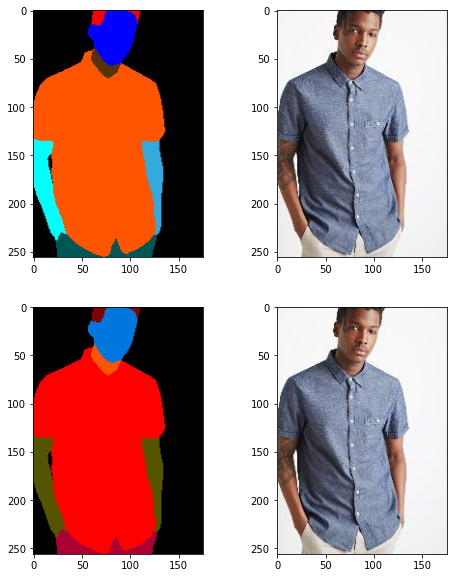

In [403]:
res = segment(os.path.join(inpath,inputs_list[1900]))